# Exercises in Fairness in Machine Learning

In [25]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import scipy.sparse

## Exercise 1

For this exercise, we will use the `adult` dataset (available on moodle or from the [UCI Machine Learning repository](https://archive.ics.uci.edu/dataset/2/adult)). Do the following:

1. Load in the dataset and correct the error in the income column (replace the "." with the empty string such that there are only two categories).
2. Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)
3. Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)
4. Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.
5. Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.
6. Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.
7. To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.)
8. Calculate the accuracy for female and male for the XGBoost model and comment on the results.
9. We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)
10. Is there error rate balance across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?
11. Is there predictive parity across different genders?
12. Is there Statistical parity across different genders?
13. [Discussion question] Can your any of your models be used to make fair salary predictions?
14. [Discussion question] In what sense is the `adult` dataset biased (unfair)?
15. [Discussion question] If the dataset is biased, where could the bias potentially come from?
16. [Optional] If you balance the number of males and females in the dataset (like we balanced the response variable in the Churn example), will you model become more fair?

In [26]:
#Load Data
df = pd.read_csv("adult.csv")

In [27]:
#Clean the income column
df["income"] = df["income"].apply(lambda x: x.strip("."))

In [28]:
#Feature & target variables selection
X = df[["age", "workclass", "education","occupation", "race", "sex","hours-per-week"]]
y = (df["income"] == ">50K").astype(int) # Binary classification target

In [29]:
#Handle missing values 
X.replace("?", "Unknown", inplace=True)
X = X.fillna("Unknown")

#Verify that missing values are eliminated
if X.isnull().sum().values.all() == 0 : print("There are no missing values")

#Verify there is not ? 
if X[X.values == "?"].empty: print("There are no more ? in the categorical data")


There are no missing values
There are no more ? in the categorical data


/var/folders/yq/94jp9phd29s5g98ng2hwj0000000gn/T/ipykernel_3420/2558761312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace("?", "Unknown", inplace=True)


In [30]:
#One hot encoding
X = pd.get_dummies(X, columns=["workclass", "education", "occupation", "race", "sex"], drop_first=True, dtype=int)

In [ ]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [32]:
#Convert to Dmatrix for optimization
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:35:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "early_stopping" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy 0.8143042380399919
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88     11109
           1       0.66      0.47      0.55      3544

    accuracy                           0.81     14653
   macro avg       0.75      0.70      0.72     14653
weighted avg       0.80      0.81      0.80     14653



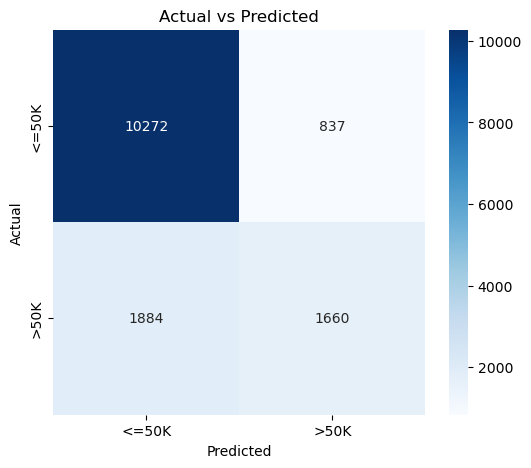

In [33]:
#Define XGBoost parameters
params = {
    "objective":"binary:logistic",
    'eval_metric':'logloss', #Try with error,
    "random_state": 42,
    "early_stopping":50,
    "max_depth":5
}

#Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

#Make prediction
y_pred = (model.predict(dtest) > 0.5).astype(int)

#Model Evaluation
print("Accuracy",accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#Plot confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Actual vs Predicted")
plt.show()


In [34]:
#Fairness analysis: Separate test sets by gender
X_test_female = X_test[X_test['sex_Male'] == 0]
X_test_male = X_test[X_test['sex_Male'] == 1]
y_test_female = y_test[X_test['sex_Male'] == 0]
y_test_male = y_test[X_test['sex_Male'] == 1]

dtest_female = xgb.DMatrix(X_test_female)
dtest_male = xgb.DMatrix(X_test_male)

y_pred_female = (model.predict(dtest_female) > 0.5).astype(int)
y_pred_male = (model.predict(dtest_male) > 0.5).astype(int)

In [35]:
#Fairness Metrics
accuracy_female = accuracy_score(y_test_female, y_pred_female)
accuracy_male = accuracy_score(y_test_male, y_pred_male)
print(f"Accuracry Female: {accuracy_female:.3f}\naccuracy Male:{accuracy_male:.3f}")

Accuracry Female: 0.890
accuracy Male:0.777


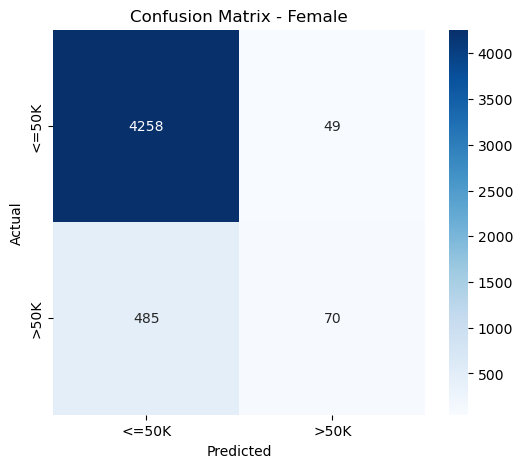

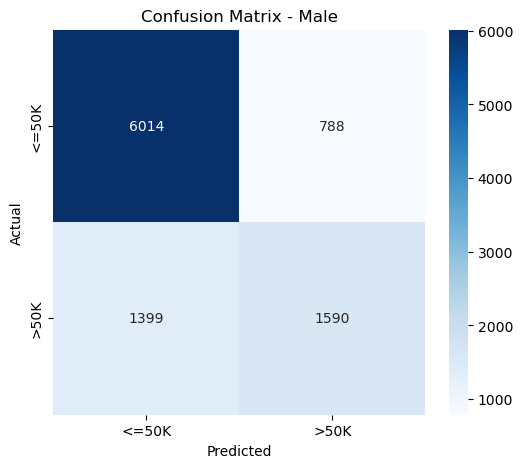

In [36]:
#Plot gender-based confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test_female, y_pred_female, "Confusion Matrix - Female")
plot_confusion_matrix(y_test_male, y_pred_male, "Confusion Matrix - Male")

In [37]:
# Confusion matrix values
TP_f = sum((y_test_female == 1) & (y_pred_female == 1))
TN_f = sum((y_test_female == 0) & (y_pred_female == 0))
FP_f = sum((y_test_female == 0) & (y_pred_female == 1))
FN_f = sum((y_test_female == 1) & (y_pred_female == 0))

TP_m = sum((y_test_male == 1) & (y_pred_male == 1))
TN_m = sum((y_test_male == 0) & (y_pred_male == 0))
FP_m = sum((y_test_male == 0) & (y_pred_male == 1))
FN_m = sum((y_test_male == 1) & (y_pred_male == 0))

print(f"TP_f: {TP_f}, TN_f: {TN_f}, FP_f: {FP_f}, FN_f: {FN_f}")
print(f"TP_m: {TP_m}, TN_m: {TN_m}, FP_m: {FP_m}, FN_m: {FN_m}")

TP_f: 70, TN_f: 4258, FP_f: 49, FN_f: 485
TP_m: 1590, TN_m: 6014, FP_m: 788, FN_m: 1399


In [38]:
# False positive & false negative rates
FPR_f = FP_f / (FP_f + TN_f)
FNR_f = FN_f / (FN_f + TP_f)
FPR_m = FP_m / (FP_m + TN_m)
FNR_m = FN_m / (FN_m + TP_m)
print(f"FPR Female: {FPR_f:.3f}, FNR Female: {FNR_f:.3f}")
print(f"FPR Male: {FPR_m:.3f}, FNR Male: {FNR_m:.3f}")

FPR Female: 0.011, FNR Female: 0.874
FPR Male: 0.116, FNR Male: 0.468
